# c6_top1000

In [1]:
import pandas as pd
c6_top1000_classification_metrics = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/c6_top1000/c6_top1000_classification_metrics.csv", index_col=0)
c6_top1000_shap_values = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/c6_top1000/c6_top1000_shap_values.csv", index_col=0)
c6_top1000_xgb_feature_importance = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/c6_top1000/c6_top1000_xgb_feature_importance.csv", index_col=0)

In [35]:
c6_top1000_classification_metrics.sort_values(by="f1-score", ascending=False)

,precision,recall,f1-score
label,,,
SBS1,0.980337,1.000000,0.990071
SBS100,0.976526,1.000000,0.988124
SBS5,0.974719,1.000000,0.987198
SBS3,0.952381,0.996441,0.973913
SBS18,0.943820,1.000000,0.971098
SBS17a,0.877358,0.994652,0.932331
overall,0.837950,0.917369,0.874263
SBS20,0.837638,0.900794,0.868069
SBS2,0.719858,0.882609,0.792969


In [14]:
c6_top1000_shap_values

,Mean_Abs_SHAP,Class
Feature,,
ELOVL2,0.322631,SBS1
SCUBE3,0.309698,SBS1
RNF128,0.300283,SBS1
SLC7A4,0.244359,SBS1
MKRN3,0.195953,SBS1
...,...,...
C4BPA,0.000000,SBS17a
C4BPB,0.000000,SBS17a
SOX10,0.000000,SBS17a


In [67]:
# Enhanced function to get top N features per class with min/max values
def get_top_n_features_per_class_with_stats(df, n=100):
    """
    Get the top N features for each class based on Mean_Abs_SHAP values
    and add min/max statistics.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'Feature', 'Mean_Abs_SHAP', and 'Class' columns
    n : int, optional (default=100)
        Number of top features to keep for each class
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with only the top N features for each class
        and additional columns for min/max statistics
    """
    # Reset index if Feature is the index
    if 'Feature' not in df.columns and df.index.name == 'Feature':
        df = df.reset_index()
    
    # Create an empty DataFrame to store results
    top_features_df = pd.DataFrame()
    
    # Get unique classes
    classes = df['Class'].unique()
    
    # For each class, select top N features
    for cls in classes:
        # Get data for this class
        class_data = df[df['Class'] == cls]
        
        # Sort by SHAP value (descending) and select top N
        top_n = class_data.sort_values('Mean_Abs_SHAP', ascending=False).head(n)
        
        # Get min and max values for this class
        min_shap = top_n['Mean_Abs_SHAP'].min()
        max_shap = top_n['Mean_Abs_SHAP'].max()
        
        # Add min and max columns
        top_n['Min_SHAP'] = min_shap
        top_n['Max_SHAP'] = max_shap
        
        # Calculate normalized SHAP values (0-1 scale)
        if max_shap > min_shap:
            top_n['Normalized_SHAP'] = (top_n['Mean_Abs_SHAP'] - min_shap) / (max_shap - min_shap)
        else:
            top_n['Normalized_SHAP'] = 1.0  # If all values are the same
        
        # Append to results
        top_features_df = pd.concat([top_features_df, top_n])
    
    return top_features_df

# Get top 100 features for each class with stats
n=10
top_features_df = get_top_n_features_per_class_with_stats(c6_top1000_shap_values, n)

# Display results
print(f"Reduced from {len(c6_top1000_shap_values)} to {len(top_features_df)} rows by keeping top {n} features per class")
print(f"Number of unique features: {top_features_df['Feature'].nunique()}")

# Show number of features per class
features_per_class = top_features_df.groupby('Class').size()
print("\nFeatures per class:")
print(features_per_class)

# Show min and max SHAP values for each class
class_stats = top_features_df.groupby('Class')[['Min_SHAP', 'Max_SHAP']].first()
print("\nMin/Max SHAP values per class:")
print(class_stats)

top_features_df

# Save to CSV with stats if needed
top_features_df.to_csv('/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/c6_top1000/c6_top1000_top10_shap_values_with_stats.csv', index=False)

Reduced from 13052 to 130 rows by keeping top 10 features per class
Number of unique features: 115

Features per class:
Class
SBS1      10
SBS100    10
SBS10d    10
SBS13     10
SBS14     10
SBS15     10
SBS17a    10
SBS18     10
SBS2      10
SBS20     10
SBS21     10
SBS3      10
SBS5      10
dtype: int64

Min/Max SHAP values per class:
        Min_SHAP  Max_SHAP
Class                     
SBS1    0.152682  0.322631
SBS100  0.145216  4.358348
SBS10d  0.124874  0.975907
SBS13   0.102258  0.266504
SBS14   0.108696  0.735372
SBS15   0.109251  0.226304
SBS17a  0.133165  2.993643
SBS18   0.128267  0.260175
SBS2    0.102656  0.496793
SBS20   0.122559  0.437237
SBS21   0.108195  0.965378
SBS3    0.125126  2.287699
SBS5    0.158715  0.475516


In [68]:
unique_features = top_features_df["Feature"].unique().tolist()
for feature in unique_features:
    print(feature)

ELOVL2
SCUBE3
RNF128
SLC7A4
MKRN3
KLK10
KRT81
KCNJ16
CAPN9
SERPINB5
SOX17
SYCP2
SYT5
GFRA3
CYP4F3
DEGS2
GRB14
EFHD1
TPSD1
UCHL1
SLC6A15
LY6G6C
CYP21A2
STK33
MMP3
AKR1B15
MT1G
PI15
UPK3B
USH1C
SERPINB2
BMPR1B
GSTT1
KRT7
SERPINB4
PSAT1
CDH2
ATP2B2
CWH43
disease_BRCA
GPAT2
AMBP
PTPRT
MAST1
EYA1
CA9
CST1
PLA2G3
TGM3
DIO1
TRPA1
SLC12A1
AKR1C1
RNF212
FMO3
ATP1A3
GABRQ
disease_CESC
SDK2
SYNPO2L
ACSS3
KRT23
DIO2
SOX2
FLRT3
PRSS21
HTR3A
DEFB1
PTPRZ1
CHIT1
WNT7A
TNNC1
ERN2
HS6ST2
KCNH3
CHRDL2
IGSF9B
SALL1
CILP
DPYSL5
GALNT14
MAPK4
IRX5
FGF18
STEAP4
PAEP
CHGA
HMGCS2
ABCA8
GSTM1
OXTR
CES3
SST
EPYC
CLDN3
CRHR1
NME5
FUT9
KCNF1
SCUBE1
PLP1
MOGAT2
CNTNAP2
CLDN10
ST6GALNAC1
TEX15
EGF
UCA1
IRX1
POU5F1
GABRB3
NMU
MT1H
UGT2B7
PRSS1


In [70]:
c6_gprofiler = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/c6_top1000/c6_top1000_top10_by_sig_gProfiler.csv")
c6_gprofiler

,source,term_name,term_id,highlighted,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections
0,GO:MF,catalytic activity,GO:0003824,True,0.026711,1.573318,5751,107,50,20196,"ELOVL2,RNF128,MKRN3,KLK10,CAPN9,CYP4F3,DEGS2,T..."
1,GO:MF,thyroxine 5'-deiodinase activity,GO:0004800,True,0.049486,1.305516,3,107,2,20196,"DIO1,DIO2"
2,GO:BP,multicellular organismal process,GO:0032501,True,0.000790,3.102637,7234,111,64,21017,"SCUBE3,RNF128,KRT81,CAPN9,SERPINB5,SOX17,SYCP2..."
3,GO:BP,endodermal cell fate specification,GO:0001714,True,0.014064,1.851891,8,111,3,21017,"SOX17,SOX2,POU5F1"
4,GO:BP,tissue development,GO:0009888,True,0.023946,1.620763,2012,111,26,21017,"KRT81,SERPINB5,SOX17,USH1C,BMPR1B,KRT7,CDH2,EY..."
5,GO:BP,system development,GO:0048731,True,0.030420,1.516837,3985,111,40,21017,"SERPINB5,SOX17,SYCP2,GFRA3,EFHD1,UCHL1,USH1C,B..."
6,GO:BP,neuron differentiation,GO:0030182,True,0.031009,1.508506,1434,111,21,21017,"GFRA3,EFHD1,UCHL1,USH1C,BMPR1B,CDH2,ATP2B2,EYA..."
7,GO:BP,cell fate commitment involved in formation of ...,GO:0060795,True,0.047845,1.320161,33,111,4,21017,"SOX17,EYA1,SOX2,POU5F1"
8,GO:CC,cell periphery,GO:0071944,True,0.003689,2.433148,6269,111,53,22115,"SCUBE3,SLC7A4,KCNJ16,SERPINB5,SYT5,GFRA3,GRB14..."
9,GO:CC,extracellular region,GO:0005576,True,0.007166,2.144701,4232,111,40,22115,"SCUBE3,KLK10,KRT81,SERPINB5,TPSD1,LY6G6C,MMP3,..."


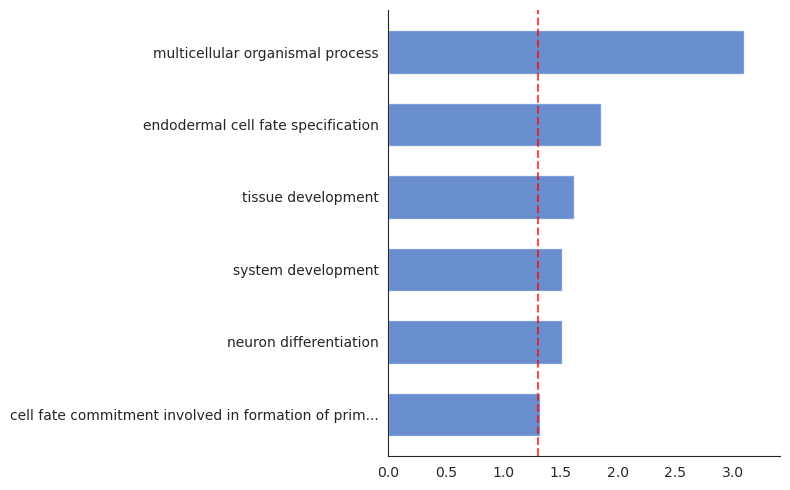

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

# Filter to only include GO:BP terms
# Use .copy() to avoid SettingWithCopyWarning
go_bp_df = c6_gprofiler[c6_gprofiler['source'] == 'GO:BP'].copy()

# Use the existing negative_log10_of_adjusted_p_value column from your dataframe
# or calculate it if you prefer
# go_bp_df.loc[:, 'negative_log10_of_adjusted_p_value'] = -np.log10(go_bp_df['adjusted_p_value'])

# Sort by negative_log10_of_adjusted_p_value in descending order and take top 10
top10_bp = go_bp_df.sort_values('negative_log10_of_adjusted_p_value', ascending=False).head(10).copy()

# Create a clean version of term names (they can be very long)
max_label_length = 50
top10_bp.loc[:, 'short_term_name'] = top10_bp['term_name'].apply(
    lambda x: x[:max_label_length] + '...' if len(x) > max_label_length else x
)

# Set up the plot with a clean style
plt.figure(figsize=(8, 5))
sns.set_style("white")

# Reverse the order for plotting (for reversed y-axis)
# This ensures the most significant pathway is at the top
top10_bp = top10_bp.sort_values('negative_log10_of_adjusted_p_value', ascending=True)

# Create the barplot with the same color for all bars
single_color = '#4472C4'  # A nice blue color
bars = plt.barh(
    y=np.arange(len(top10_bp)),
    width=top10_bp['negative_log10_of_adjusted_p_value'],
    color=single_color,
    alpha=0.8,
    height=0.6
)

# Enhance the plot - just include pathway names, no other labels
plt.yticks(np.arange(len(top10_bp)), top10_bp['short_term_name'], fontsize=10)
plt.xlabel('')  # Remove x-axis label
plt.title('')   # Remove title

# Add a vertical line at significance threshold (e.g., p=0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, color='red', linestyle='--', alpha=0.7)

# Set the x-axis limits to be slightly wider than the data
max_value = top10_bp['negative_log10_of_adjusted_p_value'].max()
plt.xlim(0, max_value * 1.1)  # Add 10% padding

# Remove spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()

# # Save the figure
# plt.savefig('/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_GO_BP_top10_barplot_clean.png', 
#            dpi=300, bbox_inches='tight')
# plt.close()

# print("Clean bar plot of top 10 GO:BP pathways saved")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

# Filter to only include GO:BP terms
# Use .copy() to avoid SettingWithCopyWarning
go_bp_df = c6_gprofiler[c6_gprofiler['source'] == 'GO:BP'].copy()

# Use the existing negative_log10_of_adjusted_p_value column from your dataframe
# or calculate it if you prefer
# go_bp_df.loc[:, 'negative_log10_of_adjusted_p_value'] = -np.log10(go_bp_df['adjusted_p_value'])

# Sort by negative_log10_of_adjusted_p_value in descending order and take top 10
top10_bp = go_bp_df.sort_values('negative_log10_of_adjusted_p_value', ascending=False).head(10).copy()

# Create a clean version of term names (they can be very long)
max_label_length = 50
top10_bp.loc[:, 'short_term_name'] = top10_bp['term_name'].apply(
    lambda x: x[:max_label_length] + '...' if len(x) > max_label_length else x
)

# Set up the plot with a clean style
plt.figure(figsize=(8, 5))
sns.set_style("white")

# Reverse the order for plotting (for reversed y-axis)
# This ensures the most significant pathway is at the top
top10_bp = top10_bp.sort_values('negative_log10_of_adjusted_p_value', ascending=True)

# Create the barplot with the same color for all bars
single_color = '#4472C4'  # A nice blue color
bars = plt.barh(
    y=np.arange(len(top10_bp)),
    width=top10_bp['negative_log10_of_adjusted_p_value'],
    color=single_color,
    alpha=0.8,
    height=0.6
)

# Enhance the plot - just include pathway names, no other labels
plt.yticks(np.arange(len(top10_bp)), top10_bp['short_term_name'], fontsize=10)
plt.xlabel('')  # Remove x-axis label
plt.title('')   # Remove title

# Add a vertical line at significance threshold (e.g., p=0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, color='red', linestyle='--', alpha=0.7)

# Set the x-axis limits to be slightly wider than the data
max_value = top10_bp['negative_log10_of_adjusted_p_value'].max()
plt.xlim(0, max_value * 1.1)  # Add 10% padding

# Remove spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()

# # Save the figure
# plt.savefig('/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_GO_BP_top10_barplot_clean.png', 
#            dpi=300, bbox_inches='tight')
# plt.close()

# print("Clean bar plot of top 10 GO:BP pathways saved")

In [4]:
c6_top1000_xgb_feature_importance

,Importance,Class
Feature,,
CHST8,6.553906,SBS1
CHST4,0.149971,SBS1
ATP1A2,1.739912,SBS1
RNF128,17.200209,SBS1
SIDT1,1.599953,SBS1
...,...,...
CRYAB,1.210838,SBS17a
ELF5,0.054520,SBS17a
SELE,4.262259,SBS17a


# l1000

In [5]:
import pandas as pd
l1000_classification_metrics = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_classification_metrics.csv", index_col=0)
l1000_shap_values = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_shap_values.csv", index_col=0)
l1000_xgb_feature_importance = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_xgb_feature_importance.csv", index_col=0)

In [6]:
l1000_classification_metrics

,precision,recall,f1-score
label,,,
SBS1,0.980337,1.000000,0.990071
SBS10d,0.653680,0.843575,0.736585
SBS13,0.627907,0.753488,0.684989
SBS14,0.550459,0.750000,0.634921
SBS15,0.600000,0.545455,0.571429
SBS18,0.943820,1.000000,0.971098
SBS2,0.717770,0.895652,0.796905
SBS20,0.848148,0.908730,0.877395
SBS21,0.710660,0.790960,0.748663


In [7]:
l1000_shap_values

,Mean_Abs_SHAP,Class
Feature,,
XPNPEP1,0.287812,SBS1
GNA11,0.241462,SBS1
BAG3,0.240802,SBS1
SPAG4,0.222558,SBS1
NUDCD3,0.194268,SBS1
...,...,...
CEP57,0.000000,SBS17a
GAPDH,0.000000,SBS17a
HDAC2,0.000000,SBS17a


In [39]:
# Get top 100 features for each class with stats
n=10
top_features_df = get_top_n_features_per_class_with_stats(l1000_shap_values, n)

# Display results
print(f"Reduced from {len(l1000_shap_values)} to {len(top_features_df)} rows by keeping top {n} features per class")
print(f"Number of unique features: {top_features_df['Feature'].nunique()}")

# Show number of features per class
features_per_class = top_features_df.groupby('Class').size()
print("\nFeatures per class:")
print(features_per_class)

# Show min and max SHAP values for each class
class_stats = top_features_df.groupby('Class')[['Min_SHAP', 'Max_SHAP']].first()
print("\nMin/Max SHAP values per class:")
print(class_stats)

top_features_df

# Save to CSV with stats if needed
# top_features_df.to_csv('/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_top10_shap_values_with_stats.csv', index=False)

Reduced from 12467 to 130 rows by keeping top 10 features per class
Number of unique features: 105

Features per class:
Class
SBS1      10
SBS100    10
SBS10d    10
SBS13     10
SBS14     10
SBS15     10
SBS17a    10
SBS18     10
SBS2      10
SBS20     10
SBS21     10
SBS3      10
SBS5      10
dtype: int64

Min/Max SHAP values per class:
        Min_SHAP  Max_SHAP
Class                     
SBS1    0.153264  0.287812
SBS100  0.134209  4.755031
SBS10d  0.148274  0.959844
SBS13   0.116633  0.243964
SBS14   0.105037  0.742940
SBS15   0.108212  0.323030
SBS17a  0.126573  3.199311
SBS18   0.143062  0.276274
SBS2    0.108919  0.578471
SBS20   0.139935  0.413537
SBS21   0.112201  1.234897
SBS3    0.144227  2.378668
SBS5    0.170601  0.282632


,Feature,Mean_Abs_SHAP,Class,Min_SHAP,Max_SHAP,Normalized_SHAP
0,XPNPEP1,0.287812,SBS1,0.153264,0.287812,1.000000
1,GNA11,0.241462,SBS1,0.153264,0.287812,0.655515
2,BAG3,0.240802,SBS1,0.153264,0.287812,0.650611
3,SPAG4,0.222558,SBS1,0.153264,0.287812,0.515015
4,NUDCD3,0.194268,SBS1,0.153264,0.287812,0.304753
...,...,...,...,...,...,...
11513,NFKBIA,0.151320,SBS17a,0.126573,3.199311,0.008054
11514,CHAC1,0.144947,SBS17a,0.126573,3.199311,0.005980
11515,SH3BP5,0.141936,SBS17a,0.126573,3.199311,0.005000
11516,CALM3,0.133154,SBS17a,0.126573,3.199311,0.002142


In [40]:
unique_features = top_features_df["Feature"].unique().tolist()
for feature in unique_features:
    print(feature)

XPNPEP1
GNA11
BAG3
SPAG4
NUDCD3
ACLY
ICMT
HS2ST1
PYCR1
SRC
PAX8
ATF1
GATA3
disease_UCEC
ELOVL6
PLS1
RPA2
disease_CESC
TSPAN3
disease_BRCA
TP53BP2
P4HTM
CCNA2
PTPRK
SPRED2
HSPA1A
PPARG
CDK7
SNCA
KCNK1
RPP38
EAPP
RB1
HMGA2
CCDC85B
CASP7
STAT5B
GADD45A
TFDP1
ACD
CEP57
DYNLT3
MTFR1
ITGAE
NNT
CGRRF1
ACOT9
HN1L
ARHGAP1
ABCC5
TLK2
DLD
PDIA5
PLP2
TOMM70A
PKIG
SOX2
BAMBI
RFX5
NUDT9
SYNGR3
NET1
MAPKAPK2
SLC35F2
CAT
CORO1A
LYPLA1
EIF4EBP1
DUSP22
POLB
PIH1D1
RPIA
ECD
C5
SLC25A13
ALDOC
TMEM110
CDK6
HYOU1
RUVBL1
PRR7
LPGAT1
NVL
PIN1
SKIV2L
ATMIN
ARFIP2
ITGB5
CDK5R1
PDGFA
MYLK
ARHGEF2
YME1L1
GATA2
CERK
HEBP1
MBTPS1
IARS2
SENP6
RBM15B
NFKBIA
CHAC1
SH3BP5
CALM3
PTGS2


In [42]:
# l1000 genes
import pandas as pd

l1000 = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/data/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt", sep="\t")
print(l1000["pr_is_lm"].value_counts())
l1000_genes = l1000["pr_gene_symbol"][l1000["pr_is_lm"]==1].tolist()

with open("/gpfs/home/yb2612/aio2025/yb2612/data/l1000_landmark_genes.txt", "w") as f:
    for gene in l1000_genes:
        f.write(f"{gene}\n")

pr_is_lm
0    11350
1      978
Name: count, dtype: int64


In [8]:
l1000_xgb_feature_importance

,Importance,Class
Feature,,
PMM2,2.943045,SBS1
NUP93,3.985633,SBS1
TGFBR2,0.189355,SBS1
NENF,0.556382,SBS1
LRPAP1,1.082491,SBS1
...,...,...
ETV1,2.636294,SBS17a
IKZF1,32.425907,SBS17a
TCEAL4,0.921267,SBS17a


In [46]:
l1000_gprofiler = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_top10_by_sig_gProfiler.csv")
l1000_gprofiler

,source,term_name,term_id,term_size,effective_domain_size,highlighted,p_adj_color,adjusted_p_value__query_1,query_size__query_1,intersection_size__query_1
0,GO:MF,protein domain specific binding,GO:0019904,655,20196,True,2.572870e-03,2.572870e-03,99,14
1,GO:MF,enzyme binding,GO:0019899,2105,20196,True,4.635393e-03,4.635393e-03,99,26
2,GO:MF,protein binding,GO:0005515,14865,20196,False,1.027591e-02,1.027591e-02,99,90
3,GO:MF,RNA polymerase II-specific DNA-binding transcr...,GO:0061629,348,20196,True,3.717514e-02,3.717514e-02,99,9
4,GO:BP,programmed cell death,GO:0012501,1980,21017,True,4.754379e-07,4.754379e-07,99,32
...,...,...,...,...,...,...,...,...,...,...
149,TF,Factor: ZNF142; motif: SNSCGCCCGCCCGCSCSS,TF:M12697,3218,20044,False,4.536042e-02,4.536042e-02,99,33
150,TF,Factor: E2F-2; motif: GCGCGCGCNCS,TF:M11529,16673,20044,False,4.669273e-02,4.669273e-02,99,96
151,MIRNA,hsa-miR-34a-5p,MIRNA:hsa-miR-34a-5p,728,14822,False,2.663407e-02,2.663407e-02,93,15
152,HPA,urinary bladder; urothelial cells[≥Low],HPA:0610831,7304,11019,False,3.184583e-02,3.184583e-02,80,68


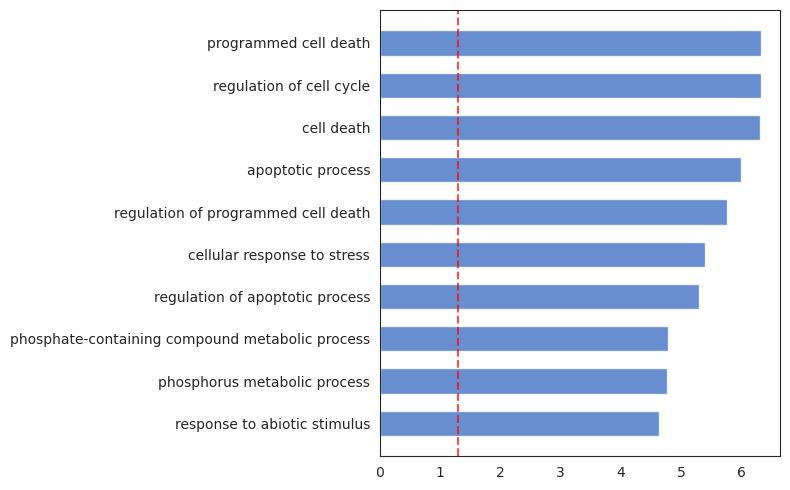

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

# Filter to only include GO:BP terms
# Use .copy() to avoid SettingWithCopyWarning
go_bp_df = l1000_gprofiler[l1000_gprofiler['source'] == 'GO:BP'].copy()

# Calculate -log10(p_adj) for sorting and plotting
go_bp_df.loc[:, '-log10_p_adj'] = -np.log10(go_bp_df['adjusted_p_value__query_1'])

# Sort by -log10(p_adj) in descending order and take top 10
top10_bp = go_bp_df.sort_values('-log10_p_adj', ascending=False).head(10).copy()

# Create a clean version of term names (they can be very long)
max_label_length = 50
top10_bp.loc[:, 'short_term_name'] = top10_bp['term_name'].apply(
    lambda x: x[:max_label_length] + '...' if len(x) > max_label_length else x
)

# Set up the plot with a clean style
plt.figure(figsize=(8, 5))
sns.set_style("white")

# Reverse the order for plotting (for reversed y-axis)
# This ensures the most significant pathway is at the top
top10_bp = top10_bp.sort_values('-log10_p_adj', ascending=True)

# Create the barplot with the same color for all bars
single_color = '#4472C4'  # A nice blue color
bars = plt.barh(
    y=np.arange(len(top10_bp)),
    width=top10_bp['-log10_p_adj'],
    color=single_color,
    alpha=0.8,
    height=0.6
)

# Enhance the plot - just include pathway names, no other labels
plt.yticks(np.arange(len(top10_bp)), top10_bp['short_term_name'], fontsize=10)
plt.xlabel('')  # Remove x-axis label
plt.title('')   # Remove title

# Remove all inner and outer annotations
# No gene ratios, no p-values on bars

# Add a vertical line at significance threshold (e.g., p=0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, color='red', linestyle='--', alpha=0.7)
# No label for the significance line

plt.tight_layout()

# Save the figure
# plt.savefig('/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_GO_BP_top10_barplot_clean.png', dpi=300, bbox_inches='tight')
# plt.close()

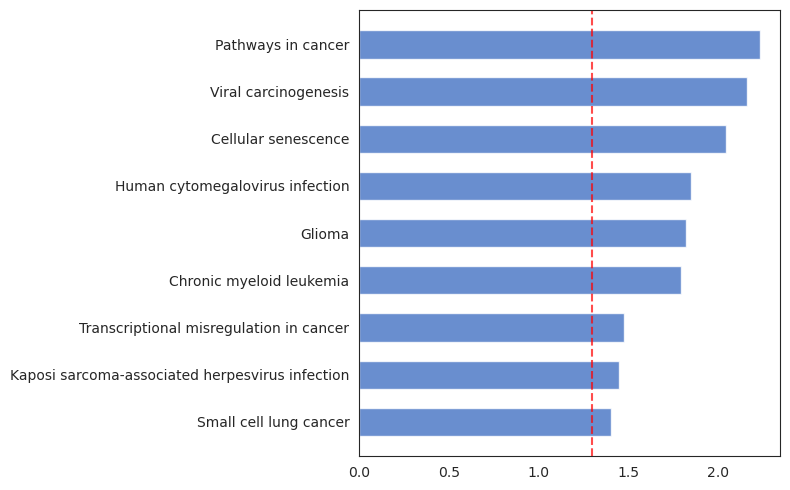

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

# Filter to only include GO:BP terms
# Use .copy() to avoid SettingWithCopyWarning
go_bp_df = l1000_gprofiler[l1000_gprofiler['source'] == 'KEGG'].copy()

# Calculate -log10(p_adj) for sorting and plotting
go_bp_df.loc[:, '-log10_p_adj'] = -np.log10(go_bp_df['adjusted_p_value__query_1'])

# Sort by -log10(p_adj) in descending order and take top 10
top10_bp = go_bp_df.sort_values('-log10_p_adj', ascending=False).head(10).copy()

# Create a clean version of term names (they can be very long)
max_label_length = 50
top10_bp.loc[:, 'short_term_name'] = top10_bp['term_name'].apply(
    lambda x: x[:max_label_length] + '...' if len(x) > max_label_length else x
)

# Set up the plot with a clean style
plt.figure(figsize=(8, 5))
sns.set_style("white")

# Reverse the order for plotting (for reversed y-axis)
# This ensures the most significant pathway is at the top
top10_bp = top10_bp.sort_values('-log10_p_adj', ascending=True)

# Create the barplot with the same color for all bars
single_color = '#4472C4'  # A nice blue color
bars = plt.barh(
    y=np.arange(len(top10_bp)),
    width=top10_bp['-log10_p_adj'],
    color=single_color,
    alpha=0.8,
    height=0.6
)

# Enhance the plot - just include pathway names, no other labels
plt.yticks(np.arange(len(top10_bp)), top10_bp['short_term_name'], fontsize=10)
plt.xlabel('')  # Remove x-axis label
plt.title('')   # Remove title

# Remove all inner and outer annotations
# No gene ratios, no p-values on bars

# Add a vertical line at significance threshold (e.g., p=0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, color='red', linestyle='--', alpha=0.7)
# No label for the significance line

plt.tight_layout()

# Save the figure
# plt.savefig('/gpfs/home/yb2612/aio2025/yb2612/results/rec2sig/classifier/l1000/l1000_GO_BP_top10_barplot_clean.png', dpi=300, bbox_inches='tight')
# plt.close()